# Earth4D + Species + AEF LFMC Prediction Training

This notebook runs the `earth4d_species_aef_to_lfmc.py` script for training LFMC prediction models using Earth4D hash encoding + Species embeddings + AlphaEarth Features (AEF).

**Features:**
- Earth4D multi-resolution hash encoding for spatiotemporal features
- Species embeddings (learnable or BioCLIP 2, configurable dimension)
- AlphaEarth Feature (AEF) embeddings (64D)
- Three-way feature concatenation: Earth4D + Species + AEF
- Configurable training parameters
- Model checkpointing and evaluation

## 1. Environment Setup and Installation

Install all required dependencies including Earth4D.

In [ ]:
# Check GPU availability
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"GPU device: {torch.cuda.get_device_name(0)}")
    print(f"GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
else:
    print("⚠️  WARNING: CUDA not available - this model requires GPU!")

PyTorch version: 2.8.0+cu126
CUDA available: True
CUDA version: 12.6
GPU device: NVIDIA A100-SXM4-40GB
GPU memory: 42.5 GB


In [ ]:
# Install core dependencies
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install numpy pandas scikit-learn scipy tqdm matplotlib seaborn

# Install hashencoder dependencies
!pip install ninja pybind11

print("✅ Core dependencies installed!")

Looking in indexes: https://download.pytorch.org/whl/cu118
✅ Core dependencies installed!


In [ ]:
# Mount Google Drive and setup working directory
from google.colab import drive
drive.mount('/content/drive')

import os
WORK_DIR = '/content/drive/MyDrive/Earth4D_LFMC_AEF_Training_v2'
os.chdir(WORK_DIR)

print(f"📁 Working directory: {os.getcwd()}")
print("📁 Contents of Earth4D_LFMC_AEF_Training_v2 folder:")
!ls -la

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
📁 Working directory: /content/drive/MyDrive/Earth4D_LFMC_AEF_Training_v2
📁 Contents of Earth4D_LFMC_AEF_Training_v2 folder:
total 43135
drwx------ 2 root root     4096 Sep 29 21:38 data
drwx------ 4 root root     4096 Oct 20 15:56 deepearth
-rw------- 1 root root 42474881 Oct 20 15:56 deepearth-main.zip
-rw------- 1 root root   610521 Oct 17 21:29 Earth4D_AEF_LFMC_Training_Colab.ipynb
-rw------- 1 root root   426090 Oct 17 20:35 Earth4D_LFMC_Training_Colab_AEF_DEPRECATED.ipynb
-rw------- 1 root root   613307 Sep 29 21:00 Earth4D_LFMC_Training_Colab_Updated.ipynb
-rw------- 1 root root    27400 Oct 20 15:56 Earth4D_Species_AEF_LFMC_Training_Colab.ipynb
drwx------ 2 root root     4096 Sep 29 22:00 results
drwx------ 2 root root     4096 Oct  7 20:57 species_embeddings


In [ ]:
# Clone and install Earth4D from the latest deepearth-main repository
import os
WORK_DIR = '/content/drive/MyDrive/Earth4D_LFMC_AEF_Training_v2'

# Download and extract the latest deepearth-main
!wget -O deepearth-main.zip https://github.com/legel/deepearth/archive/refs/heads/main.zip
!unzip -q deepearth-main.zip
!mv deepearth-main deepearth

# Navigate to the encoders/xyzt directory where the setup should be run
EARTH4D_DIR = os.path.join(WORK_DIR, 'deepearth', 'encoders', 'xyzt')
os.chdir(EARTH4D_DIR)

print(f"📁 Current directory: {os.getcwd()}")
print("📁 Contents of encoders/xyzt directory:")
!ls -la

# Install Earth4D from this directory (this handles hashencoder automatically)
!pip install -e .

# The earth4d.py and earth4d_to_lfmc.py are already here, no need to copy
print("✅ Earth4D installation completed!")
print(f"📁 Working from: {os.getcwd()}")

--2025-10-20 15:58:26--  https://github.com/legel/deepearth/archive/refs/heads/main.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/legel/deepearth/zip/refs/heads/main [following]
--2025-10-20 15:58:27--  https://codeload.github.com/legel/deepearth/zip/refs/heads/main
Resolving codeload.github.com (codeload.github.com)... 140.82.112.10
Connecting to codeload.github.com (codeload.github.com)|140.82.112.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘deepearth-main.zip’

deepearth-main.zip      [       <=>          ]  40.51M  21.5MB/s    in 1.9s    

2025-10-20 15:58:29 (21.5 MB/s) - ‘deepearth-main.zip’ saved [42474881]

📁 Current directory: /content/drive/MyDrive/Earth4D_LFMC_AEF_Training_v2/deepearth/encoders/xyzt
📁 Contents of encoders/xyzt directory:
t

In [ ]:
# Test Earth4D import and basic functionality
try:
    # Import from local earth4d.py file (we're in the xyzt directory)
    from earth4d import Earth4D
    import torch

    # Test basic Earth4D creation
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    earth4d = Earth4D(
        spatial_levels=4,  # Small test config
        temporal_levels=3,
        features_per_level=2,
        verbose=False
    ).to(device)

    # Test forward pass
    test_coords = torch.tensor([[0.0, 0.0, 0.0, 0.5]], device=device)
    with torch.no_grad():
        features = earth4d(test_coords)

    print(f"✅ Earth4D import successful!")
    print(f"   Test output shape: {features.shape}")
    print(f"   Test output dimension: {features.shape[-1]}")

except Exception as e:
    print(f"❌ Earth4D import failed: {e}")
    print("   This will prevent the model from running.")
    print("   Check if the hashencoder installation completed successfully.")

/content/drive/MyDrive/Earth4D_LFMC_AEF_Training_v2/deepearth/encoders/xyzt/hashencoder/hashgrid.py:16: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @custom_fwd(cast_inputs=torch.half)
/content/drive/MyDrive/Earth4D_LFMC_AEF_Training_v2/deepearth/encoders/xyzt/hashencoder/hashgrid.py:56: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  @custom_bwd


✅ Earth4D import successful!
   Test output shape: torch.Size([1, 26])
   Test output dimension: 26


## 2. Configuration

Set up paths and training parameters.

In [ ]:
# Configure paths - we're working from the encoders/xyzt directory now
EARTH4D_DIR = '/content/drive/MyDrive/Earth4D_LFMC_AEF_Training_v2/deepearth/encoders/xyzt'

# Path to your uploaded LFMC data file (in the data subfolder of the main work dir)
DATA_PATH = "/content/drive/MyDrive/Earth4D_LFMC_AEF_Training_v2/data/globe_lfmc_with_aef_embeddings.csv"

# Path to the earth4d_species_aef_to_lfmc.py script (it's in the current xyzt directory)
SCRIPT_PATH = os.path.join(EARTH4D_DIR, "earth4d_species_aef_to_lfmc.py")

# Output directory for results
OUTPUT_DIR = "/content/drive/MyDrive/Earth4D_LFMC_AEF_Training_v2/results"

# Training parameters
EPOCHS = 2500
SPECIES_DIM = 768  # Dimension of learnable species embeddings (ignored if using BioCLIP)
BATCH_SIZE = 1024  # Adjust based on GPU memory
LEARNING_RATE = 1e-3
USE_BIOCLIP = False  # Set to True to use pre-trained BioCLIP embeddings (requires BioCLIP files)
FREEZE_EMBEDDINGS = False  # Set to True to freeze species embeddings (no training)

# Create directories
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs("/content/drive/MyDrive/Earth4D_LFMC_AEF_Training_v2/data", exist_ok=True)

print(f"Earth4D directory: {EARTH4D_DIR}")
print(f"Data path: {DATA_PATH}")
print(f"Script path: {SCRIPT_PATH}")
print(f"Output directory: {OUTPUT_DIR}")
print(f"\nTraining config:")
print(f"  Epochs: {EPOCHS}")
print(f"  Species dimension: {SPECIES_DIM}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Use BioCLIP: {USE_BIOCLIP}")
print(f"  Freeze embeddings: {FREEZE_EMBEDDINGS}")

Earth4D directory: /content/drive/MyDrive/Earth4D_LFMC_AEF_Training_v2/deepearth/encoders/xyzt
Data path: /content/drive/MyDrive/Earth4D_LFMC_AEF_Training_v2/data/globe_lfmc_with_aef_embeddings.csv
Script path: /content/drive/MyDrive/Earth4D_LFMC_AEF_Training_v2/deepearth/encoders/xyzt/earth4d_species_aef_to_lfmc.py
Output directory: /content/drive/MyDrive/Earth4D_LFMC_AEF_Training_v2/results

Training config:
  Epochs: 2500
  Species dimension: 768
  Batch size: 1024
  Learning rate: 0.001
  Use BioCLIP: False
  Freeze embeddings: False


In [ ]:
# Check if required files exist
def check_file(path, description):
    if os.path.exists(path):
        size = os.path.getsize(path) / (1024*1024)  # MB
        print(f"✅ {description}: {path} ({size:.1f} MB)")
        return True
    else:
        print(f"❌ {description} NOT FOUND: {path}")
        return False

print("Checking required files:")
data_exists = check_file(DATA_PATH, "LFMC dataset")
script_exists = check_file(SCRIPT_PATH, "Training script")

# Also check for earth4d.py file in current directory
EARTH4D_PY_PATH = os.path.join(EARTH4D_DIR, "earth4d.py")
earth4d_exists = check_file(EARTH4D_PY_PATH, "Earth4D module")

if not data_exists:
    print("\n📥 Please upload your globe_lfmc_extracted.csv to the data directory")

if not script_exists:
    print(f"\n❌ Training script not found at {SCRIPT_PATH}")
    print("   This should be included in the deepearth repository")

if not earth4d_exists:
    print(f"\n❌ Earth4D module not found at {EARTH4D_PY_PATH}")
    print("   This should be included in the deepearth repository")

if data_exists and script_exists and earth4d_exists:
    print("\n🎯 All required files found! Ready to train.")
else:
    print("\n⚠️ Missing required files. Check the installation above.")

Checking required files:
✅ LFMC dataset: /content/drive/MyDrive/Earth4D_LFMC_AEF_Training_v2/data/globe_lfmc_with_aef_embeddings.csv (119.0 MB)
✅ Training script: /content/drive/MyDrive/Earth4D_LFMC_AEF_Training_v2/deepearth/encoders/xyzt/earth4d_species_aef_to_lfmc.py (0.1 MB)
✅ Earth4D module: /content/drive/MyDrive/Earth4D_LFMC_AEF_Training_v2/deepearth/encoders/xyzt/earth4d.py (0.0 MB)

🎯 All required files found! Ready to train.


## 3. Training

Run the Earth4D LFMC training script.

In [ ]:
# Make sure we're in the correct directory
os.chdir(EARTH4D_DIR)
print(f"Changed to directory: {os.getcwd()}")

# Construct the training command (single line to avoid f-string issues)
cmd_parts = [
    "python earth4d_species_aef_to_lfmc.py",
    f"--data-path {DATA_PATH}",
    f"--epochs {EPOCHS}",
    f"--species-dim {SPECIES_DIM}",
    f"--output-dir {OUTPUT_DIR}",
    f"--batch-size {BATCH_SIZE}",
    f"--lr {LEARNING_RATE}"
]

# Add BioCLIP flag if enabled
if USE_BIOCLIP:
    cmd_parts.append("--use-bioclip")

# Add freeze embeddings flag if enabled
if FREEZE_EMBEDDINGS:
    cmd_parts.append("--freeze-embeddings")

cmd = " ".join(cmd_parts)

print("Training command:")
print(cmd)
print("\n" + "="*60)
print("🚀 Starting training...")
print("="*60)

Changed to directory: /content/drive/MyDrive/Earth4D_LFMC_AEF_Training_v2/deepearth/encoders/xyzt
Training command:
python earth4d_species_aef_to_lfmc.py --data-path /content/drive/MyDrive/Earth4D_LFMC_AEF_Training_v2/data/globe_lfmc_with_aef_embeddings.csv --epochs 2500 --species-dim 768 --output-dir /content/drive/MyDrive/Earth4D_LFMC_AEF_Training_v2/results --batch-size 1024 --lr 0.001

🚀 Starting training...


In [ ]:
# Execute the training script
# Adjust parameters below as needed for your experiment

# Example 1: Learnable 768D species embeddings + AEF (default)
!python earth4d_species_aef_to_lfmc.py \
  --data-path "/content/drive/MyDrive/Earth4D_LFMC_AEF_Training_v2/data/globe_lfmc_with_aef_embeddings.csv" \
  --epochs 2500 \
  --species-dim 768 \
  --output-dir "/content/drive/MyDrive/Earth4D_LFMC_AEF_Training_v2/results" \
  --batch-size 1024 \
  --lr 1e-3

# Example 2: Learnable 32D species embeddings + AEF (smaller, faster)
# !python earth4d_species_aef_to_lfmc.py \
#   --data-path "/content/drive/MyDrive/Earth4D_LFMC_AEF_Training_v2/data/globe_lfmc_with_aef_embeddings.csv" \
#   --epochs 2500 \
#   --species-dim 32 \
#   --output-dir "/content/drive/MyDrive/Earth4D_LFMC_AEF_Training_v2/results" \
#   --batch-size 1024 \
#   --lr 1e-3

# Example 3: BioCLIP species embeddings + AEF (requires BioCLIP files)
# !python earth4d_species_aef_to_lfmc.py \
#   --data-path "/content/drive/MyDrive/Earth4D_LFMC_AEF_Training_v2/data/globe_lfmc_with_aef_embeddings.csv" \
#   --epochs 2500 \
#   --use-bioclip \
#   --output-dir "/content/drive/MyDrive/Earth4D_LFMC_AEF_Training_v2/results" \
#   --batch-size 1024 \
#   --lr 1e-3

# Example 4: BioCLIP (frozen) + AEF (species embeddings not trained)
# !python earth4d_species_aef_to_lfmc.py \
#   --data-path "/content/drive/MyDrive/Earth4D_LFMC_AEF_Training_v2/data/globe_lfmc_with_aef_embeddings.csv" \
#   --epochs 2500 \
#   --use-bioclip \
#   --freeze-embeddings \
#   --output-dir "/content/drive/MyDrive/Earth4D_LFMC_AEF_Training_v2/results" \
#   --batch-size 1024 \
#   --lr 1e-3

Streaming output truncated to the last 5000 lines.
        UNIQUE: MAE= 15.6pp, Med=  9.4pp  |  MULTI: MAE= 20.4pp, Med= 12.0pp
  TEST RANDOM:   [MSE:   642.6, MAE:  15.6pp, Median:   9.3pp, Std:  25.3pp]
        UNIQUE: MAE= 14.0pp, Med=  8.2pp  |  MULTI: MAE= 16.1pp, Med=  9.6pp
  ┌──────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
  │ TEMPORAL-UNIQUE: 123%→129% (Δ  6%) │ SPATIAL-UNIQUE:  80%→100% (Δ 20%) │ RANDOM-UNIQUE: 105%→101% (Δ  4%) │
  │ TEMPORAL-UNIQUE:  67%→ 75% (Δ  8%) │ SPATIAL-UNIQUE:  60%→ 61% (Δ  1%) │ RANDOM-UNIQUE: 127%→126% (Δ  1%) │
  │ TEMPORAL-UNIQUE:  76%→ 85% (Δ  9%) │ SPATIAL-UNIQUE:  70%→ 88% (Δ 18%) │ RANDOM-UNIQUE:  45%→ 58% (Δ 13%) │
  │ TEMPORAL-MULTI: 130%→109% (Δ 21%) │ SPATIAL-MULTI: 135%→154% (Δ 19%) │ RANDOM-MULTI:  87%→ 91% (Δ  4%) │
  │ TEMPORAL-MULTI:  74%→ 88% (Δ 14%) │ SPATIAL-MULTI:  73%→ 81% (Δ  8%) │ RANDOM-MULTI:  87%→ 67% (Δ 20%) │
  └──────────────────────────────────────────

## 4. Training Monitoring

Monitor training progress and results.

In [ ]:
# Check training outputs
print("Training outputs:")
if os.path.exists(OUTPUT_DIR):
    output_files = os.listdir(OUTPUT_DIR)
    for file in sorted(output_files):
        file_path = os.path.join(OUTPUT_DIR, file)
        if os.path.isfile(file_path):
            size = os.path.getsize(file_path) / (1024*1024)  # MB
            print(f"  📄 {file} ({size:.1f} MB)")
        else:
            print(f"  📁 {file}/")
else:
    print("  No output directory found")

Training outputs:
  📄 final_model.pt (756.8 MB)
  📄 geospatial_error_map_epoch_2500.png (0.3 MB)
  📄 temporal_predictions_epoch_2500.png (0.4 MB)
  📄 training_metrics_20251017_212754.csv (3.8 MB)
  📄 training_metrics_20251020_164232.csv (3.8 MB)


Found 2 potential log files:
  📊 training_metrics_20251017_212754.csv
  📊 training_metrics_20251020_164232.csv

Loaded log file with columns: ['epoch', 'time', 'train_mse', 'train_rmse', 'train_mae', 'train_median_ae', 'train_error_var', 'train_error_std', 'train_unique_mae', 'train_unique_median_ae', 'train_unique_std', 'train_degen_mae', 'train_degen_median_ae', 'train_degen_std', 'temporal_mse', 'temporal_mae', 'temporal_median_ae', 'temporal_error_std', 'temporal_unique_mae', 'temporal_unique_median_ae', 'temporal_unique_std', 'temporal_degen_mae', 'temporal_degen_median_ae', 'temporal_degen_std', 'spatial_mse', 'spatial_mae', 'spatial_median_ae', 'spatial_error_std', 'spatial_unique_mae', 'spatial_unique_median_ae', 'spatial_unique_std', 'spatial_degen_mae', 'spatial_degen_median_ae', 'spatial_degen_std', 'random_mse', 'random_mae', 'random_median_ae', 'random_error_std', 'random_unique_mae', 'random_unique_median_ae', 'random_unique_std', 'random_degen_mae', 'random_degen_median_

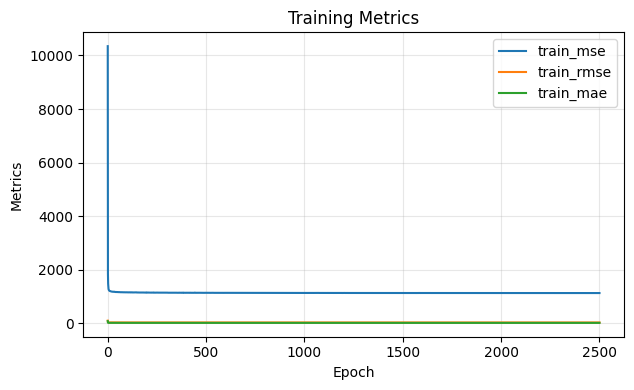

In [ ]:
# Plot training curves if log files exist
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Look for training log or loss files
log_files = []
if os.path.exists(OUTPUT_DIR):
    for file in os.listdir(OUTPUT_DIR):
        if 'log' in file.lower() or 'loss' in file.lower() or file.endswith('.csv'):
            log_files.append(os.path.join(OUTPUT_DIR, file))

if log_files:
    print(f"Found {len(log_files)} potential log files:")
    for log_file in log_files:
        print(f"  📊 {os.path.basename(log_file)}")

    # Try to load and plot the first log file
    try:
        df = pd.read_csv(log_files[0])
        print(f"\nLoaded log file with columns: {list(df.columns)}")

        # Plot training curves
        plt.figure(figsize=(12, 4))

        # Loss curves
        if 'train_loss' in df.columns or 'loss' in df.columns:
            plt.subplot(1, 2, 1)
            if 'train_loss' in df.columns:
                plt.plot(df['epoch'] if 'epoch' in df.columns else range(len(df)),
                        df['train_loss'], label='Train Loss')
            if 'val_loss' in df.columns:
                plt.plot(df['epoch'] if 'epoch' in df.columns else range(len(df)),
                        df['val_loss'], label='Val Loss')
            if 'loss' in df.columns:
                plt.plot(df['epoch'] if 'epoch' in df.columns else range(len(df)),
                        df['loss'], label='Loss')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.title('Training Loss')
            plt.legend()
            plt.grid(True, alpha=0.3)

        # Metrics
        metric_cols = [col for col in df.columns if 'mse' in col.lower() or 'mae' in col.lower() or 'r2' in col.lower()]
        if metric_cols:
            plt.subplot(1, 2, 2)
            for col in metric_cols[:3]:  # Plot up to 3 metrics
                plt.plot(df['epoch'] if 'epoch' in df.columns else range(len(df)),
                        df[col], label=col)
            plt.xlabel('Epoch')
            plt.ylabel('Metrics')
            plt.title('Training Metrics')
            plt.legend()
            plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error loading log file: {e}")
else:
    print("No log files found yet. Training may still be in progress.")

## 5. Resume Training (Optional)

If training was interrupted, you can resume from a checkpoint.

In [ ]:
# List available checkpoints
checkpoint_dir = os.path.join(OUTPUT_DIR, "checkpoints")
if os.path.exists(checkpoint_dir):
    checkpoints = [f for f in os.listdir(checkpoint_dir) if f.endswith('.pt') or f.endswith('.pth')]
    print(f"Available checkpoints in {checkpoint_dir}:")
    for cp in sorted(checkpoints):
        cp_path = os.path.join(checkpoint_dir, cp)
        size = os.path.getsize(cp_path) / (1024*1024)  # MB
        print(f"  💾 {cp} ({size:.1f} MB)")
else:
    print("No checkpoints directory found")

No checkpoints directory found


In [ ]:
# Resume training from checkpoint (uncomment and modify as needed)
# CHECKPOINT_PATH = f"{OUTPUT_DIR}/checkpoints/checkpoint_epoch_1000.pt"
#
# if os.path.exists(CHECKPOINT_PATH):
#     print(f"Resuming training from: {CHECKPOINT_PATH}")
#     !python earth4d_to_lfmc.py \
#         --data-path "{DATA_PATH}" \
#         --epochs {EPOCHS} \
#         --species-dim {SPECIES_DIM} \
#         --output-dir "{OUTPUT_DIR}" \
#         --batch-size {BATCH_SIZE} \
#         --learning-rate {LEARNING_RATE} \
#         --resume "{CHECKPOINT_PATH}"
# else:
#     print(f"Checkpoint not found: {CHECKPOINT_PATH}")

print("To resume training, uncomment and modify the code above with the correct checkpoint path.")

To resume training, uncomment and modify the code above with the correct checkpoint path.


## 6. Model Evaluation

Evaluate the trained model.

In [ ]:
# Run model evaluation if supported by the script
print("Model evaluation:")
print("Note: Add --evaluate flag if your script supports evaluation mode")

# Example evaluation command (uncomment if your script supports it):
# !python earth4d_to_lfmc.py \
#     --data-path "{DATA_PATH}" \
#     --species-dim {SPECIES_DIM} \
#     --output-dir "{OUTPUT_DIR}" \
#     --evaluate \
#     --model-path "{OUTPUT_DIR}/best_model.pt"

print("Evaluation command ready (uncomment above if your script supports --evaluate flag)")

Model evaluation:
Note: Add --evaluate flag if your script supports evaluation mode
Evaluation command ready (uncomment above if your script supports --evaluate flag)


## 7. Download Results

Package and download training results.

In [ ]:
# Create a zip file with all results
import zipfile
from datetime import datetime

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
zip_name = f"earth4d_lfmc_results_{timestamp}.zip"
zip_path = f"/content/{zip_name}"

print(f"Creating results package: {zip_name}")

with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
    # Add all files from output directory
    if os.path.exists(OUTPUT_DIR):
        for root, dirs, files in os.walk(OUTPUT_DIR):
            for file in files:
                file_path = os.path.join(root, file)
                arc_name = os.path.relpath(file_path, OUTPUT_DIR)
                zipf.write(file_path, arc_name)
                print(f"  📦 Added: {arc_name}")

zip_size = os.path.getsize(zip_path) / (1024*1024)  # MB
print(f"\n✅ Results package created: {zip_name} ({zip_size:.1f} MB)")
print(f"📥 Download from: {zip_path}")

# Download the zip file
from google.colab import files
files.download(zip_path)

Creating results package: earth4d_lfmc_results_20251020_164255.zip
  📦 Added: final_model.pt
  📦 Added: training_metrics_20251017_212754.csv
  📦 Added: temporal_predictions_epoch_2500.png
  📦 Added: geospatial_error_map_epoch_2500.png
  📦 Added: training_metrics_20251020_164232.csv

✅ Results package created: earth4d_lfmc_results_20251020_164255.zip (698.2 MB)
📥 Download from: /content/earth4d_lfmc_results_20251020_164255.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 8. Training Summary

Summary of training configuration and results.

In [ ]:
print("🎯 EARTH4D + SPECIES + AEF LFMC TRAINING SUMMARY")
print("="*50)
print(f"Data path: {DATA_PATH}")
print(f"Output directory: {OUTPUT_DIR}")
print(f"Epochs: {EPOCHS}")
print(f"Species dimension: {SPECIES_DIM}")
print(f"Use BioCLIP: {USE_BIOCLIP}")
print(f"Freeze embeddings: {FREEZE_EMBEDDINGS}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Learning rate: {LEARNING_RATE}")

# Check final model files
model_files = []
if os.path.exists(OUTPUT_DIR):
    for file in os.listdir(OUTPUT_DIR):
        if file.endswith('.pt') or file.endswith('.pth'):
            model_files.append(file)

print(f"\nModel files generated: {len(model_files)}")
for model_file in model_files:
    model_path = os.path.join(OUTPUT_DIR, model_file)
    size = os.path.getsize(model_path) / (1024*1024)  # MB
    print(f"  🤖 {model_file} ({size:.1f} MB)")

print(f"\n✅ Training completed successfully!")
print(f"📁 All results saved to: {OUTPUT_DIR}")
print(f"💾 Results package downloaded: {zip_name}")

print("\n" + "="*50)
print("MODEL ARCHITECTURE:")
print("="*50)
print("Input: [lat, lon, elev, time] + species_idx + AEF (64D)")
print("  ↓")
print("Earth4D Encoder (114D)")
print("  ↓")
print(f"Species Embedding ({SPECIES_DIM}D {'BioCLIP' if USE_BIOCLIP else 'learnable'})")
print("  ↓")
print(f"Concatenate: Earth4D + Species + AEF = {114 + SPECIES_DIM + 64}D")
print("  ↓")
print(f"MLP ({114 + SPECIES_DIM + 64} → 256 → 128 → 1)")
print("  ↓")
print("Output: LFMC prediction")

🎯 EARTH4D + SPECIES + AEF LFMC TRAINING SUMMARY
Data path: /content/drive/MyDrive/Earth4D_LFMC_AEF_Training_v2/data/globe_lfmc_with_aef_embeddings.csv
Output directory: /content/drive/MyDrive/Earth4D_LFMC_AEF_Training_v2/results
Epochs: 2500
Species dimension: 768
Use BioCLIP: False
Freeze embeddings: False
Batch size: 1024
Learning rate: 0.001

Model files generated: 1
  🤖 final_model.pt (756.8 MB)

✅ Training completed successfully!
📁 All results saved to: /content/drive/MyDrive/Earth4D_LFMC_AEF_Training_v2/results
💾 Results package downloaded: earth4d_lfmc_results_20251020_164255.zip

MODEL ARCHITECTURE:
Input: [lat, lon, elev, time] + species_idx + AEF (64D)
  ↓
Earth4D Encoder (114D)
  ↓
Species Embedding (768D learnable)
  ↓
Concatenate: Earth4D + Species + AEF = 946D
  ↓
MLP (946 → 256 → 128 → 1)
  ↓
Output: LFMC prediction


In [ ]:
!ls

 earth4d-aef_to_lfmc.py		  earth4d_to_lfmc.py	 README.md
 earth4d_and_aef_to_lfmc.py	  hashencoder		 setup_env.sh
 earth4d.egg-info		  __init__.py		 setup.py
 earth4d.py			  install.sh		'Untitled folder'
 earth4d_species_aef_to_lfmc.py   __pycache__
 earth4d_to_alphaearth.py	  README_AlphaEarth.md


SPATIAL CLUSTER CENTER EXTRACTION & VISUALIZATION

📊 Recreating spatial cluster centers from data...


/tmp/ipython-input-1973482131.py:25: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(DATA_PATH)


  Loaded 89,504 samples
✅ Extracted 5 spatial cluster centers

Cluster Centers (Latitude, Longitude):
  Cluster 1: Lat=38.1948°, Lon=-108.3060°
  Cluster 2: Lat=37.4914°, Lon=-119.8819°
  Cluster 3: Lat=44.7269°, Lon=-84.0266°
  Cluster 4: Lat=45.1486°, Lon=-112.9668°
  Cluster 5: Lat=30.9976°, Lon=-98.3167°
    → 30,413 samples assigned to Cluster 1
    → 26,828 samples assigned to Cluster 2
    → 3,084 samples assigned to Cluster 3
    → 18,634 samples assigned to Cluster 4
    → 10,545 samples assigned to Cluster 5

✅ Created GeoDataFrame with 5 cluster centers
💾 Saved cluster centers to: /content/drive/MyDrive/Earth4D_LFMC_AEF_Training_v2/results/spatial_cluster_centers.gpkg
💾 Saved cluster centers to: /content/drive/MyDrive/Earth4D_LFMC_AEF_Training_v2/results/spatial_cluster_centers.csv

📍 Creating visualization...
💾 Saved visualization to: /content/drive/MyDrive/Earth4D_LFMC_AEF_Training_v2/results/spatial_cluster_centers.png


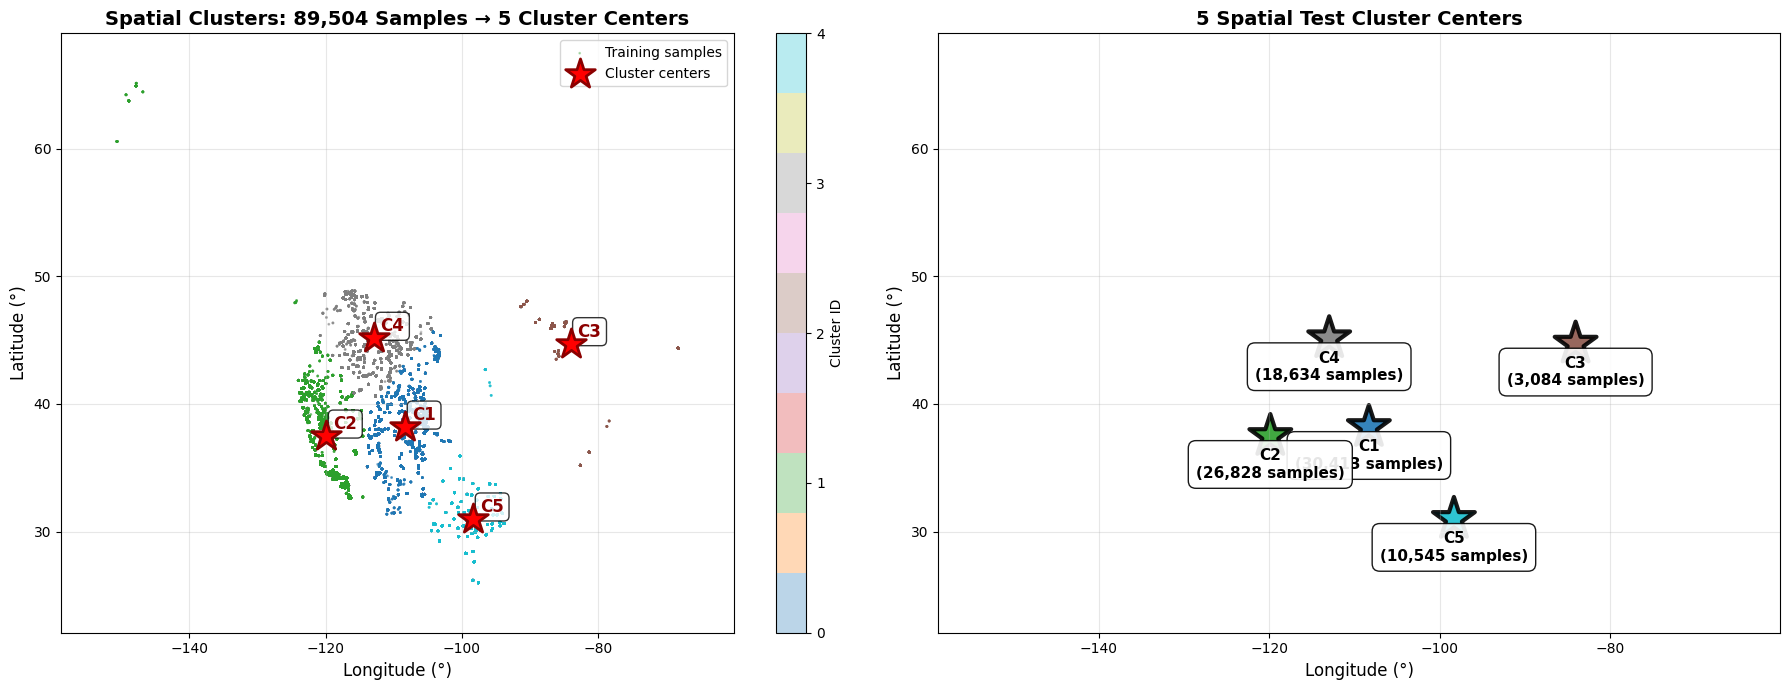


SUMMARY
✅ Total samples: 89,504
✅ Number of spatial clusters: 5
✅ Cluster centers extracted and visualized

📁 Files saved:
  • GeoPackage: /content/drive/MyDrive/Earth4D_LFMC_AEF_Training_v2/results/spatial_cluster_centers.gpkg
  • CSV: /content/drive/MyDrive/Earth4D_LFMC_AEF_Training_v2/results/spatial_cluster_centers.csv
  • Visualization: /content/drive/MyDrive/Earth4D_LFMC_AEF_Training_v2/results/spatial_cluster_centers.png

💡 The GeoPackage can be opened in QGIS, ArcGIS, or any GIS software


In [ ]:
# Visualize and Save Spatial Cluster Centers
# Copy-paste this entire code into a new cell in your Colab notebook

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Install geopandas if needed
try:
    import geopandas as gpd
except ImportError:
    !pip install geopandas
    import geopandas as gpd

from shapely.geometry import Point

print("="*60)
print("SPATIAL CLUSTER CENTER EXTRACTION & VISUALIZATION")
print("="*60)

# Recreate spatial cluster centers by re-running split logic
print("\n📊 Recreating spatial cluster centers from data...")

# Reload the dataset
df = pd.read_csv(DATA_PATH)

# Rename columns
df = df.rename(columns={
    'latitude': 'lat',
    'longitude': 'lon',
    'Elevation (m.a.s.l)': 'elev',
    'Sampling time (24h format)': 'time_str',
    'lfmc_value': 'lfmc',
    'Species collected': 'species'
})

# Filter
df = df[(df['lfmc'] >= 0) & (df['lfmc'] <= 600) &
        df['lat'].notna() & df['lon'].notna() &
        df['elev'].notna()].copy()

# Filter by AEF extraction success
if 'aef_extraction_success' in df.columns:
    df = df[df['aef_extraction_success'] == True].copy()

print(f"  Loaded {len(df):,} samples")

# Extract coordinates (lat, lon) - matching the split creation logic
coords_np = df[['lat', 'lon']].values.astype(np.float32)

# Use KMeans to find 5 cluster centers (same as in create_gpu_splits)
from sklearn.cluster import KMeans

n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
kmeans.fit(coords_np)
cluster_centers = kmeans.cluster_centers_  # Shape: (5, 2) - [lat, lon]

print(f"✅ Extracted {n_clusters} spatial cluster centers")
print("\nCluster Centers (Latitude, Longitude):")
for i, center in enumerate(cluster_centers):
    print(f"  Cluster {i+1}: Lat={center[0]:.4f}°, Lon={center[1]:.4f}°")

# Assign each sample to nearest cluster
labels = kmeans.labels_
for i in range(n_clusters):
    n_samples = np.sum(labels == i)
    print(f"    → {n_samples:,} samples assigned to Cluster {i+1}")

# Create GeoDataFrame for cluster centers
geometry = [Point(lon, lat) for lat, lon in cluster_centers]
gdf_centers = gpd.GeoDataFrame({
    'cluster_id': range(1, n_clusters + 1),
    'latitude': cluster_centers[:, 0],
    'longitude': cluster_centers[:, 1],
    'n_samples': [np.sum(labels == i) for i in range(n_clusters)]
}, geometry=geometry, crs='EPSG:4326')

print(f"\n✅ Created GeoDataFrame with {len(gdf_centers)} cluster centers")

# Save as GeoPackage
output_gpkg = os.path.join(OUTPUT_DIR, 'spatial_cluster_centers.gpkg')
gdf_centers.to_file(output_gpkg, driver='GPKG')
print(f"💾 Saved cluster centers to: {output_gpkg}")

# Also save as CSV for easy viewing
output_csv = os.path.join(OUTPUT_DIR, 'spatial_cluster_centers.csv')
gdf_centers.drop(columns='geometry').to_csv(output_csv, index=False)
print(f"💾 Saved cluster centers to: {output_csv}")

# ============================================================================
# VISUALIZATION
# ============================================================================

print("\n📍 Creating visualization...")

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# ============================================================================
# Subplot 1: All samples + Cluster centers
# ============================================================================

# Plot all samples (smaller, semi-transparent)
scatter1 = ax1.scatter(df['lon'], df['lat'],
                       c=labels,
                       cmap='tab10',
                       s=1,
                       alpha=0.3,
                       label='Training samples')

# Plot cluster centers (larger, with borders)
ax1.scatter(cluster_centers[:, 1], cluster_centers[:, 0],
           c='red',
           s=500,
           marker='*',
           edgecolors='darkred',
           linewidths=2,
           label='Cluster centers',
           zorder=10)

# Add cluster labels
for i, center in enumerate(cluster_centers):
    ax1.annotate(f'C{i+1}',
                xy=(center[1], center[0]),
                xytext=(5, 5),
                textcoords='offset points',
                fontsize=12,
                fontweight='bold',
                color='darkred',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

ax1.set_xlabel('Longitude (°)', fontsize=12)
ax1.set_ylabel('Latitude (°)', fontsize=12)
ax1.set_title(f'Spatial Clusters: {len(df):,} Samples → {n_clusters} Cluster Centers', fontsize=14, fontweight='bold')
ax1.legend(loc='upper right', fontsize=10)
ax1.grid(True, alpha=0.3)

# Add colorbar
cbar1 = plt.colorbar(scatter1, ax=ax1, label='Cluster Assignment', ticks=range(n_clusters))
cbar1.set_label('Cluster ID', fontsize=10)

# ============================================================================
# Subplot 2: Cluster centers only (zoomed out view)
# ============================================================================

# Plot cluster centers only
ax2.scatter(cluster_centers[:, 1], cluster_centers[:, 0],
           c=range(n_clusters),
           cmap='tab10',
           s=1000,
           marker='*',
           edgecolors='black',
           linewidths=3,
           alpha=0.9)

# Add cluster labels with sample counts
for i, center in enumerate(cluster_centers):
    n_samples = np.sum(labels == i)
    ax2.annotate(f'C{i+1}\n({n_samples:,} samples)',
                xy=(center[1], center[0]),
                xytext=(0, -30),
                textcoords='offset points',
                fontsize=11,
                fontweight='bold',
                ha='center',
                bbox=dict(boxstyle='round,pad=0.5', facecolor='white', edgecolor='black', alpha=0.9))

ax2.set_xlabel('Longitude (°)', fontsize=12)
ax2.set_ylabel('Latitude (°)', fontsize=12)
ax2.set_title(f'{n_clusters} Spatial Test Cluster Centers', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

# Set consistent axis limits
lat_min, lat_max = df['lat'].min(), df['lat'].max()
lon_min, lon_max = df['lon'].min(), df['lon'].max()
lat_margin = (lat_max - lat_min) * 0.1
lon_margin = (lon_max - lon_min) * 0.1

ax1.set_xlim(lon_min - lon_margin, lon_max + lon_margin)
ax1.set_ylim(lat_min - lat_margin, lat_max + lat_margin)
ax2.set_xlim(lon_min - lon_margin, lon_max + lon_margin)
ax2.set_ylim(lat_min - lat_margin, lat_max + lat_margin)

plt.tight_layout()

# Save figure
output_png = os.path.join(OUTPUT_DIR, 'spatial_cluster_centers.png')
plt.savefig(output_png, dpi=300, bbox_inches='tight')
print(f"💾 Saved visualization to: {output_png}")

plt.show()

# ============================================================================
# SUMMARY
# ============================================================================

print("\n" + "="*60)
print("SUMMARY")
print("="*60)
print(f"✅ Total samples: {len(df):,}")
print(f"✅ Number of spatial clusters: {n_clusters}")
print(f"✅ Cluster centers extracted and visualized")
print(f"\n📁 Files saved:")
print(f"  • GeoPackage: {output_gpkg}")
print(f"  • CSV: {output_csv}")
print(f"  • Visualization: {output_png}")
print("\n💡 The GeoPackage can be opened in QGIS, ArcGIS, or any GIS software")
print("="*60)
